In [1]:
import torch 
from torch import nn
from torch.nn import init
import torch.utils.data as data_utils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
SEED = 2019
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [2]:
from RcmModelClass import GMF
from RcmModelClass import NCF
from RcmModelClass import ConvNCF
from RcmModelClass import ENMF

In [3]:
dataset = np.loadtxt('../ml-1m/ratings.dat', delimiter='::', usecols=[0,1,3], dtype=int)
N_USER = np.max(dataset[:,0])
N_ITEM = np.max(dataset[:,1])

In [4]:
def generate_train_from_local(path, n_user, n_item):
    data = np.loadtxt(fname=path, delimiter="\t", skiprows=1, dtype=int)
    train_matrix = np.zeros((n_user, n_item), dtype = np.int8)
    for line in data:
        train_matrix[line[0],line[1]] = 1
    return data, train_matrix

def generate_test_from_local(path):
    data = np.loadtxt(fname=path, delimiter="\t", skiprows=1, dtype=int)
    return data

train, train_matrix = generate_train_from_local(path="../ml-1m/ml.train.txt", n_user=N_USER, n_item=N_ITEM)
test  = generate_test_from_local(path="../ml-1m/ml.test.txt")

number of items:  3705
number of flows:  994169
avg of S(x):  268.0
parameter phi:  0.00027
parameter epsilon should less than or equal phi
sketch belongs to half of the stream
phi = 0.00027
S = 994169
r = 4
w = 1000


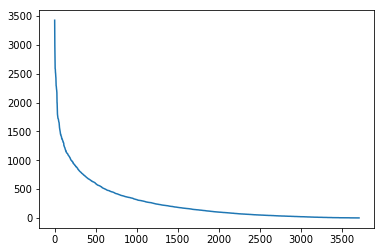

In [5]:
def veiwData(dataset):
    n_users  = np.max(dataset[:,0])
    n_items  = np.max(dataset[:,1])
    avgS     = round(len(dataset) / n_items, 0)
    itemFreq = [0 for x in range(n_items)]
    for record in dataset:
        itemFreq[record[1]-1] += 1
    realHH = set()
    for i,n in enumerate(itemFreq):
        if n >= avgS:
            realHH.add(i+1)
    itemFreq.sort(reverse=True)
    plt.plot(range(len(itemFreq)), itemFreq)
    print("number of items: ", n_items)
    print("number of flows: ", len(dataset))
    print("avg of S(x): ", avgS)
    print("parameter phi: ", round(1 / n_items, 5))
    print("parameter epsilon should less than or equal phi")
    print("sketch belongs to half of the stream")
    return realHH, round(1 / n_items, 5), dataset.shape[0]

realHH, phi, S = veiwData(train)
print("phi =", phi)
print("S =", S)
delta   = 0.05
epsilon = 0.002
r = round(np.log2(1 / delta)).astype(np.int)
w = round(2 / epsilon)
print("r =", r)
print("w =", w)

In [6]:
class HHtracer():
    def __init__(self, sketch_width, sketch_deep):
        self.sketch_width = sketch_width
        self.sketch_deep  = sketch_deep 
        self.sketch = [[(0,0,0) for x in range(sketch_width)] for y in range(sketch_deep)]
        return
    
    def processStream_HH(self, dataset):
        for record in dataset:
            item = (record[1], 1)
            self.update(item)
        return
    
    def update(self, item):
        x  = item[0]
        vx = item[1]
        for i in range(self.sketch_deep):
            np.random.seed(i + x)
            j = np.random.choice(self.sketch_width)
            V = self.sketch[i][j][0] + vx
            K = self.sketch[i][j][1]
            C = self.sketch[i][j][2]
            if K == x:
                C += vx
            else:
                C -= vx
                if C < 0:
                    K = x
                    C = -C
            self.sketch[i][j] = (V, K, C)
        return
    
    def queryU(self, x):
        res_list = list()
        for i in range(self.sketch_deep):
            np.random.seed(i + x)
            j = np.random.choice(self.sketch_width)
            V = self.sketch[i][j][0]
            K = self.sketch[i][j][1]
            C = self.sketch[i][j][2] 
            if K == x:
                S = (V + C) / 2
            else:
                S = (V - C) / 2
            res_list.append(S)
        return min(res_list)   
    
    def hitter(self, phi, S):
        print("heavy hitter threshold: ", phi * S)
        hh = dict()
        for i in range(self.sketch_deep):
            for j in range(self.sketch_width):
                if self.sketch[i][j][0] >= phi * S:
                    x = self.sketch[i][j][1]
                    freq = self.queryU(x)
                    if freq >= phi * S:
                        if x not in hh.keys() or (x in hh.keys() and hh[x] < freq):
                            hh[x] = freq
        return hh
    
    def getHH(self, dataset, phi, S):
        self.processStream_HH(dataset)
        hh = self.hitter(phi, S)
        return hh
    
    def evaluateHH(self, res, real):
        tp = fp = fn = 0
        for i in res:
            if i in real:
                tp += 1
            else:
                fp += 1
        for j in real:
            if j not in res:
                fn += 1
        print("TP =",tp,"   FP =", fp,"   FN =", fn)
        recall = tp / (tp + fn)
        print('reacall:', recall)
        precision = tp / (tp + fp)
        print('precision:',precision)
        f1 = (2 * recall * precision) / (precision + recall)
        print('F1-score:',f1)
        return
    
    def rank(self, hhDict, test, topK=100):
        res = sorted(hhDict.items(), key=lambda item:item[1], reverse=True)[:topK]
        ranklist = list()
        for line in res:
            ranklist.append(line[0])
        hr, ndcg = self.evaluate(ranklist, test)
        print('HR@', topK, ' = %.4f' %  hr)
        print('NDCG@', topK, ' = %.4f' % ndcg)
        return hr, ndcg, ranklist
    
    def getHitRatio(self, ranklist, gtItem):
        #HR击中率，如果topk中有正例ID即认为正确
        if gtItem in ranklist:
            return 1
        return 0

    def getNDCG(self, ranklist, gtItem):
        #NDCG归一化折损累计增益
        for i in range(len(ranklist)):
            item = ranklist[i]
            if item == gtItem:
                return np.log(2) / np.log(i+2)
        return 0

    def evaluate(self, ranklist, test):
        hit_list = list()
        undcg_list = list()
        for line in test:
            user = line[0]
            pos_item = line[1]
            hit_list.append(self.getHitRatio(ranklist, pos_item))
            undcg_list.append(self.getNDCG(ranklist, pos_item))
        hr = np.mean(hit_list)
        ndcg = np.mean(undcg_list)
        return hr, ndcg

In [7]:
hh_tracer = HHtracer(w, r)
hhDict = hh_tracer.getHH(train, phi, S)
resHH = list(set(hhDict.keys()))
hh_tracer.evaluateHH(resHH, realHH)

heavy hitter threshold:  268.42563
TP = 1058    FP = 36    FN = 95
reacall: 0.9176062445793582
precision: 0.9670932358318098
F1-score: 0.9417000445037828


In [8]:
def pop_eval_topk(hh_tracer, TOPK=[50,100,200]):
    hr_list = list()
    ndcg_list = list()
    for k in TOPK:
        hr,ndcg,ranklist = hh_tracer.rank(hhDict, test, topK=k)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        np.savetxt("./evalres/pop/hr_list_topk.txt", hr_list)
        np.savetxt("./evalres/pop/ndcg_list_topk.txt", ndcg_list)
    return

pop_eval_topk(hh_tracer)

HR@ 50  = 0.1828
NDCG@ 50  = 0.0372
HR@ 100  = 0.1949
NDCG@ 100  = 0.0391
HR@ 200  = 0.2614
NDCG@ 200  = 0.0483


In [9]:
def getHitRatio(ranklist, gtItem):
    #HR击中率，如果topk中有正例ID即认为正确
    if gtItem in ranklist: 
        return 1
    return 0

def getNDCG(ranklist, gtItem):
    #NDCG归一化折损累计增益
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return np.log(2) / np.log(i+2)
    return 0

In [10]:
def ncf_fine(model, train_matrix, test, rough_rank, topK = 100):
    rough_rank = np.array(rough_rank)
    n_user = train_matrix.shape[0]
    n_item = len(rough_rank)
    model.eval()
    rank_all_users = list()
    hit_list = list()
    undcg_list = list()
    with torch.no_grad():
        for u, pos_item in test:
            item_list = torch.from_numpy(rough_rank.reshape(-1, 1)).type(torch.LongTensor)
            user_list = torch.from_numpy(np.array([u for i in range(n_item)]).reshape(-1, 1)).type(torch.LongTensor)
            if torch.cuda.is_available():
                user_list, item_list = user_list.cuda(), item_list.cuda()
            prediction = model(user_list, item_list)
            pred_vector = -1 * (prediction.cpu().data.numpy().reshape(-1))
            ranklist = rough_rank[np.argsort(pred_vector)]
            real_r = list()
            i = 0
            while len(real_r) < topK and i < n_item:
                if train_matrix[u][ranklist[i]] == 0:
                    real_r.append(ranklist[i])
                i += 1
            rank_all_users.append(real_r)
            hit_list.append(getHitRatio(real_r, pos_item))
            undcg_list.append(getNDCG(real_r, pos_item))
    model.train()
    hr = np.mean(hit_list)
    ndcg = np.mean(undcg_list)
    print('HR@', topK, ' = %.4f' %  hr)
    print('NDCG@', topK, ' = %.4f' % ndcg)
    return hr, ndcg, rank_all_users


def pop_mix_ncf_eval_topk(ncf, train_matrix, test, rough_rank, TOPK=[50,100,200]):
    hr_list = list()
    ndcg_list = list()
    for k in TOPK:
        hr, ndcg, rank_all_users = ncf_fine(ncf, train_matrix, test, rough_rank, topK = k)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        np.savetxt("./evalres/pop-ncf/hr_list_topk.txt", hr_list)
        np.savetxt("./evalres/pop-ncf/ndcg_list_topk.txt", ndcg_list)
    return

ncf = torch.load("./evalres/model/NCF.pkl")
pop_mix_ncf_eval_topk(ncf, train_matrix, test, rough_rank=resHH)

HR@ 50  = 0.2417
NDCG@ 50  = 0.0743
HR@ 100  = 0.3705
NDCG@ 100  = 0.0951
HR@ 200  = 0.5157
NDCG@ 200  = 0.1154


In [11]:
def convNCF_fine(model, train_matrix, test, rough_rank, topK = 100):
    rough_rank = np.array(rough_rank)
    n_user = train_matrix.shape[0]
    n_item = len(rough_rank)
    model.eval()
    rank_all_users = list()
    hit_list = list()
    undcg_list = list()  
    with torch.no_grad():
        for u, pos_item in test:
            item_list = torch.from_numpy(rough_rank.reshape(-1, 1)).type(torch.LongTensor)
            user_list = torch.from_numpy(np.array([u for i in range(n_item)]).reshape(-1, 1)).type(torch.LongTensor)
            if torch.cuda.is_available():
                user_list, item_list = user_list.cuda(), item_list.cuda()
            prediction, _ = model(user_list, item_list, None, train = False)
            pred_vector = -1 * (prediction.cpu().data.numpy().reshape(-1))
            ranklist = rough_rank[np.argsort(pred_vector)]
            real_r = list()
            i = 0
            while len(real_r) < topK and i < n_item:
                if train_matrix[u][ranklist[i]] == 0:
                    real_r.append(ranklist[i])
                i += 1
            rank_all_users.append(real_r)
            hit_list.append(getHitRatio(real_r, pos_item))
            undcg_list.append(getNDCG(real_r, pos_item))
    model.train()
    hr = np.mean(hit_list)
    ndcg = np.mean(undcg_list)
    print('HR@', topK, ' = %.4f' %  hr)
    print('NDCG@', topK, ' = %.4f' % ndcg)
    return hr, ndcg, rank_all_users

def pop_mix_convcf_eval_topk(convNCF, train_matrix, test, rough_rank, TOPK=[50,100,200]):
    hr_list = list()
    ndcg_list = list()
    for k in TOPK:
        hr, ndcg, rank_all_users = convNCF_fine(convNCF, train_matrix, test, rough_rank, topK = k)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        np.savetxt("./evalres/pop-convncf/hr_list_topk.txt", hr_list)
        np.savetxt("./evalres/pop-convncf/ndcg_list_topk.txt", ndcg_list)
    return

convNCF = torch.load("./evalres/model/ConvNCF.pkl")
pop_mix_convcf_eval_topk(convNCF, train_matrix, test, rough_rank=resHH)

HR@ 50  = 0.1369
NDCG@ 50  = 0.0349
HR@ 100  = 0.2255
NDCG@ 100  = 0.0493
HR@ 200  = 0.3086
NDCG@ 200  = 0.0610


In [14]:
torch_test = torch.from_numpy(test).type(torch.LongTensor)
torch_testset = data_utils.TensorDataset(torch_test[:,0],torch_test[:,1])
test_loader = data_utils.DataLoader(dataset = torch_testset, batch_size = 128, num_workers = 0)

def enmf_fine(model, train_matrix, test_loader, rough_rank, topK = 100):
    n_users = train_matrix.shape[0]
    rank_all_users = list()
    hit_list = list()
    undcg_list = list()  
    model.eval()
    with torch.no_grad(): 
        for step, (batch_x, batch_y) in enumerate(test_loader):
            if torch.cuda.is_available():
                batch_x = batch_x.cuda()  
            prediction = model.rank(batch_x)
            pred_vector = -1 * (prediction.cpu().data.numpy())
            ranklist = np.argsort(pred_vector)
            for j, r in enumerate(ranklist):
                real_r = list()
                u = batch_x[j].cpu().data.numpy()
                pos_item = batch_y[j].cpu().data.numpy()
                for i in r:
                    if i in rough_rank:
                        real_r.append(i)
                    if len(real_r) >= topK:
                        break
                rank_all_users.append(real_r)
                hit_list.append(getHitRatio(real_r, pos_item))
                undcg_list.append(getNDCG(real_r, pos_item))
    model.train()
    hr = np.mean(hit_list)
    ndcg = np.mean(undcg_list)
    print('HR@', topK, ' = %.4f' %  hr)
    print('NDCG@', topK, ' = %.4f' % ndcg)
    return hr, ndcg, rank_all_users


def pop_mix_enmf_eval_topk(enmf, train_matrix, test_loader, rough_rank, TOPK=[50,100,200]):
    hr_list = list()
    ndcg_list = list()
    for k in TOPK:
        hr, ndcg, rank_all_users = enmf_fine(enmf, train_matrix, test_loader, rough_rank, topK = k)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        np.savetxt("./evalres/pop-enmf/hr_list_topk.txt", hr_list)
        np.savetxt("./evalres/pop-enmf/ndcg_list_topk.txt", ndcg_list)
    return

enmf = torch.load("./evalres/model/ENMF.pkl")
pop_mix_enmf_eval_topk(enmf, train_matrix, test_loader, rough_rank=resHH)

HR@ 50  = 0.1488
NDCG@ 50  = 0.0362
HR@ 100  = 0.2853
NDCG@ 100  = 0.0582
HR@ 200  = 0.4634
NDCG@ 200  = 0.0831
